In [1]:
import ccxt
import numpy as np
import pandas as pd
import datetime as dt
from dateutil import tz
import matplotlib.pyplot as plt

import json
import time
import os
import sys

In [2]:
src_path = '../src/'
sys.path.append(os.path.abspath(src_path))
import func_get
import func_signal
import func_backtest

In [3]:
start_ts = time.time()

In [4]:
interval_dict = {
    '1m': 1,
    '5m': 5,
    '15m': 15,
    '30m': 30,
    '1h': 60,
    '2h': 120,
    '4h': 240,
    '1d': 1440
}

In [5]:
with open('../../../_keys/ftx/ftx_read_keys.json') as keys_file:
    keys_dict = json.load(keys_file)
    
exchange = ccxt.ftx({'apiKey': keys_dict['apiKey'],
                     'secret': keys_dict['secret'],
                     'enableRateLimit': True})

### Config

In [6]:
project_name = 'cross'

In [7]:
start_date = dt.datetime(2022, 1, 1)
start_hour = 1
end_date = dt.datetime.today() - dt.timedelta(days=1)
reinvest_profit_flag = True

In [8]:
config_params = {
    'safety_ohlcv_range': 1000,
    'action_timeframe': '15m',
    'target_side': ['buy'],
    'base': {
        'symbol': ['ETH-PERP'],
        'open': {
            '15m': {
                'cross_sma': {
                    'check': ['check_signal_side_change'],
                    'look_back': 1,
                    'short_windows': 15,
                    'long_windows': 200,
                    'revert': False
                }
            }
        },
        'close': {
            '15m': {
                'cross_sma': {
                    'check': ['check_signal_side'],
                    'look_back': 1,
                    'short_windows': 15,
                    'long_windows': 200,
                    'revert': False
                }
            }
        }
    },
    'lead': {
        'symbol': [],
        'open': {
        },
        'close': {
        }
    },
    'tp': {
        'stop_percent': 100,
        'price_percent': None,
        'signal': None,
    },
    'sl': {
        'stop_percent': 100,
        'price_percent': None,
        'signal': None
    },
    'action_percent': 100,
    'leverage': 1,
    'taker_fee_percent': 0.07
}

### Get data

In [9]:
ohlcv_df_dict = func_get.get_data(exchange, start_date, end_date, start_hour, interval_dict, config_params)

base: timeframe 1/1 symbol 1/1 date 1/130
base: timeframe 1/1 symbol 1/1 date 2/130
base: timeframe 1/1 symbol 1/1 date 3/130
base: timeframe 1/1 symbol 1/1 date 4/130
base: timeframe 1/1 symbol 1/1 date 5/130
base: timeframe 1/1 symbol 1/1 date 6/130
base: timeframe 1/1 symbol 1/1 date 7/130
base: timeframe 1/1 symbol 1/1 date 8/130
base: timeframe 1/1 symbol 1/1 date 9/130
base: timeframe 1/1 symbol 1/1 date 10/130
base: timeframe 1/1 symbol 1/1 date 11/130
base: timeframe 1/1 symbol 1/1 date 12/130
base: timeframe 1/1 symbol 1/1 date 13/130
base: timeframe 1/1 symbol 1/1 date 14/130
base: timeframe 1/1 symbol 1/1 date 15/130
base: timeframe 1/1 symbol 1/1 date 16/130
base: timeframe 1/1 symbol 1/1 date 17/130
base: timeframe 1/1 symbol 1/1 date 18/130
base: timeframe 1/1 symbol 1/1 date 19/130
base: timeframe 1/1 symbol 1/1 date 20/130
base: timeframe 1/1 symbol 1/1 date 21/130
base: timeframe 1/1 symbol 1/1 date 22/130
base: timeframe 1/1 symbol 1/1 date 23/130
base: timeframe 1/1 

### Add signal

In [10]:
ohlcv_df_dict = func_signal.add_signal(start_date, ohlcv_df_dict, interval_dict, config_params)

base add cross_sma to ETH-PERP 15m
base add cross_sma to ETH-PERP 15m


### Back test

In [11]:
action_time_list = func_get.gen_action_time_list(config_params, ohlcv_df_dict)
max_open_timeframe = func_backtest.get_max_open_timeframe(config_params, interval_dict)

In [12]:
budget = 100

transaction_dict = {
    'symbol': [],
    'side': [],
    'amount': [],
    'open_time': [],
    'open_price': [],
    'close_time': [],
    'close_price': [],
    'value': [],
    'notional': [],
    'profit': [],
    'profit_percent': []
}

position_dict = {}

if reinvest_profit_flag == True:
    budget_dict = {
        'time': [],
        'budget': []
    }
    
max_drawdown = 0

In [13]:
if reinvest_profit_flag == True:
    min_budget = budget

time_count = 0

for signal_time in action_time_list:
    action_time = signal_time + dt.timedelta(minutes=interval_dict[config_params['action_timeframe']])
    
    time_count += 1
    print(f"Time {action_time}: progress {time_count}/{len(action_time_list)}")

    '''
    Close positions
    '''
    for symbol in [x for x in position_dict.keys()]:
        print(f"  {symbol}")
        budget, max_drawdown, position_dict, transaction_dict = func_backtest.close_position(symbol, signal_time, max_drawdown, config_params, budget, reinvest_profit_flag, ohlcv_df_dict, position_dict, transaction_dict, interval_dict)

    '''
    Open positions
    '''
    max_position = int(1 / (config_params['action_percent'] / 100))

    for symbol in [x for x in config_params['base']['symbol'] if x not in position_dict.keys()][:max_position]:
        print(f"  {symbol}")
        position_dict = func_backtest.open_position(symbol, signal_time, max_open_timeframe, config_params, budget, ohlcv_df_dict, position_dict, interval_dict)    
    
    '''
    Update budget
    '''
    if reinvest_profit_flag == True:
        budget_dict['time'].append(signal_time)
        budget_dict['budget'].append(budget)

        if budget < min_budget:
            min_budget = budget

    if budget <= 0:
        print(f"Out of money at {action_time}")
        break
        
'''
Clear final position
'''
opened_symbol = list(position_dict.keys())

for symbol in opened_symbol:
    print(f" Clear {symbol} position")
    
    side = position_dict[symbol]['side']
    ohlcv_df = ohlcv_df_dict['base'][config_params['action_timeframe']][symbol]
    current_ohlcv_df = ohlcv_df[ohlcv_df['time'] == signal_time].reset_index(drop=True)
    close_price = current_ohlcv_df.loc[0, 'close']
    close_percent = 100
    
    budget, position_dict, transaction_dict = func_backtest.update_close_position(symbol, side, close_price, close_percent, signal_time, config_params, budget, reinvest_profit_flag, position_dict, transaction_dict, interval_dict)

Time 2022-01-01 00:15:00: progress 1/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-01 00:30:00: progress 2/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-01 00:45:00: progress 3/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-01 01:00:00: progress 4/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-01 01:15:00: progress 5/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-01 01:30:00: progress 6/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-01 01:45:00: progress 7/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-01 02:00:00: progress

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-02 18:00:00: progress 168/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-02 18:15:00: progress 169/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-02 18:30:00: progress 170/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-02 18:45:00: progress 171/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-02 19:00:00: progress 172/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-02 19:15:00: progress 173/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-02 19:30:00: progress 174/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-02 19:45:00: progress 175/1

Time 2022-01-04 05:00:00: progress 308/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-04 05:15:00: progress 309/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-04 05:30:00: progress 310/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-04 05:45:00: progress 311/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-04 06:00:00: progress 312/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-04 06:15:00: progress 313/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-04 06:30:00: progress 314/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-04 06:4

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-05 10:45:00: progress 427/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-05 11:00:00: progress 428/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-05 11:15:00: progress 429/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-05 11:30:00: progress 430/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-05 11:45:00: progress 431/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-05 12:00:00: progress 432/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-05 12:15:00: progress 433/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-05 12:30:00: progress 434/1

     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-07 01:15:00: progress 581/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-07 01:30:00: progress 582/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-07 01:45:00: progress 583/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-07 02:00:00: progress 584/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-07 02:15:00: progress 585/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-07 02:30:00: progress 586/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-07 02:45:00: progress 587/11428
  ETH-PERP
     base ETH-PERP c

     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-08 04:15:00: progress 689/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-08 04:30:00: progress 690/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-08 04:45:00: progress 691/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-08 05:00:00: progress 692/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-08 05:15:00: progress 693/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-08 05:30:00: progress 694/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-08 05:45:00: progress 695/11428
  ETH-PERP
     base ETH-PERP c

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-10 03:45:00: progress 879/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-10 04:00:00: progress 880/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-10 04:15:00: progress 881/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-10 04:30:00: progress 882/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-10 04:45:00: progress 883/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-10 05:00:00: progress 884/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-10 05:15:00: progress 885/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-10 05:30:00: progress 886/1

     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-10 21:15:00: progress 949/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-10 21:30:00: progress 950/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-10 21:45:00: progress 951/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-10 22:00:00: progress 952/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-10 22:15:00: progress 953/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-10 22:30:00: progress 954/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-10 22:45:00: progress 955/11428
  ETH-PERP
     base ETH-PERP c

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-12 11:00:00: progress 1100/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-12 11:15:00: progress 1101/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-12 11:30:00: progress 1102/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-12 11:45:00: progress 1103/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-12 12:00:00: progress 1104/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-12 12:15:00: progress 1105/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-12 12:30:00: progress 1106/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-12 12:45:00: progres

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-13 10:00:00: progress 1192/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-13 10:15:00: progress 1193/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-13 10:30:00: progress 1194/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-13 10:45:00: progress 1195/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-13 11:00:00: progress 1196/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-13 11:15:00: progress 1197/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-13 11:30:00: progress 1198/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-13 11:45:00: progres

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-15 08:00:00: progress 1376/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-15 08:15:00: progress 1377/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-15 08:30:00: progress 1378/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-15 08:45:00: progress 1379/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-15 09:00:00: progress 1380/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-15 09:15:00: progress 1381/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-15 09:30:00: progress 1382/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-15 09:45:00: progres

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-16 03:00:00: progress 1452/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-16 03:15:00: progress 1453/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-16 03:30:00: progress 1454/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-16 03:45:00: progress 1455/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-16 04:00:00: progress 1456/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-16 04:15:00: progress 1457/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-16 04:30:00: progress 1458/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-16 04:45:00: progres

     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-17 12:45:00: progress 1587/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-17 13:00:00: progress 1588/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-17 13:15:00: progress 1589/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-17 13:30:00: progress 1590/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-17 13:45:00: progress 1591/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-17 14:00:00: progress 1592/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-17 14:15:00: progress 1593/11428
  ETH-PERP
     base ETH

     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-18 12:45:00: progress 1683/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-18 13:00:00: progress 1684/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-18 13:15:00: progress 1685/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-18 13:30:00: progress 1686/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-18 13:45:00: progress 1687/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-18 14:00:00: progress 1688/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-18 14:15:00: progress 1689/11428
  ETH-PERP
     base ETH

     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-20 07:00:00: progress 1852/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-20 07:15:00: progress 1853/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-20 07:30:00: progress 1854/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-20 07:45:00: progress 1855/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-20 08:00:00: progress 1856/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-20 08:15:00: progress 1857/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-20 08:30:00: progress 1858/11428
  ETH-PERP
     base ETH

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-21 05:45:00: progress 1943/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-21 06:00:00: progress 1944/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-21 06:15:00: progress 1945/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-21 06:30:00: progress 1946/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: sell
     Closed by signal at 3020.0
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: sell
     No action
Time 2022-01-21 06:45:00: progress 1947/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-21 07:00:00: progress 1948/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-21 07:15:00: p

  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-23 15:15:00: progress 2173/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-23 15:30:00: progress 2174/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-23 15:45:00: progress 2175/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-23 16:00:00: progress 2176/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-23 16:15:00: progress 2177/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-23 16:30:00: progress 2178/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-23 16:45:00: progress 2179/11428
  ETH-PERP
  

     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-24 17:00:00: progress 2276/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-24 17:15:00: progress 2277/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-24 17:30:00: progress 2278/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-24 17:45:00: progress 2279/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-24 18:00:00: progress 2280/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-24 18:15:00: progress 2281/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-24 18:30:00: progress 2282/11428
  ETH-PERP
     base ETH

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-26 07:30:00: progress 2430/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-26 07:45:00: progress 2431/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-26 08:00:00: progress 2432/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-26 08:15:00: progress 2433/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-26 08:30:00: progress 2434/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-26 08:45:00: progress 2435/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-26 09:00:00: progress 2436/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-26 09:15:00: progres

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-27 00:45:00: progress 2499/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-27 01:00:00: progress 2500/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-27 01:15:00: progress 2501/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-27 01:30:00: progress 2502/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-27 01:45:00: progress 2503/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-27 02:00:00: progress 2504/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-27 02:15:00: progress 2505/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-27 02:30:00: progres

     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-28 16:00:00: progress 2656/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-28 16:15:00: progress 2657/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-28 16:30:00: progress 2658/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-28 16:45:00: progress 2659/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-28 17:00:00: progress 2660/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-28 17:15:00: progress 2661/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-28 17:30:00: progress 2662/11428
  ETH-PERP
     base ETH

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-29 09:15:00: progress 2725/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-29 09:30:00: progress 2726/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-29 09:45:00: progress 2727/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-29 10:00:00: progress 2728/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-29 10:15:00: progress 2729/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-29 10:30:00: progress 2730/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-29 10:45:00: progress 2731/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-29 11:00:00: progres

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-31 01:15:00: progress 2885/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-31 01:30:00: progress 2886/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-31 01:45:00: progress 2887/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-31 02:00:00: progress 2888/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-31 02:15:00: progress 2889/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-31 02:30:00: progress 2890/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-31 02:45:00: progress 2891/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-31 03:00:00: progres

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-01 01:15:00: progress 2981/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-01 01:30:00: progress 2982/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-01 01:45:00: progress 2983/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-01 02:00:00: progress 2984/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-01 02:15:00: progress 2985/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-01 02:30:00: progress 2986/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-01 02:45:00: progress 2987/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-01 03:00:00: progres

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-02 14:15:00: progress 3129/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-02 14:30:00: progress 3130/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-02 14:45:00: progress 3131/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-02 15:00:00: progress 3132/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-02 15:15:00: progress 3133/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-02 15:30:00: progress 3134/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-02 15:45:00: progress 3135/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-02 16:00:00: progres

     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-03 07:00:00: progress 3196/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-03 07:15:00: progress 3197/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-03 07:30:00: progress 3198/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-03 07:45:00: progress 3199/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-03 08:00:00: progress 3200/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-03 08:15:00: progress 3201/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-03 08:30:00: progress 3202/11428
  ETH-PERP
     base ETH

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-04 22:45:00: progress 3355/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-04 23:00:00: progress 3356/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-04 23:15:00: progress 3357/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-04 23:30:00: progress 3358/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-04 23:45:00: progress 3359/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-05 00:00:00: progress 3360/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-05 00:15:00: progress 3361/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-05 00:30:00: progres

     base ETH-PERP check_signal_side cross_sma 15m: sell
     Closed by signal at 2994.4
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: sell
     No action
Time 2022-02-07 00:00:00: progress 3552/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-07 00:15:00: progress 3553/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-07 00:30:00: progress 3554/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-07 00:45:00: progress 3555/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-07 01:00:00: progress 3556/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-07 01:15:00: progress 3557/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: 

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-07 19:30:00: progress 3630/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-07 19:45:00: progress 3631/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-07 20:00:00: progress 3632/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-07 20:15:00: progress 3633/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-07 20:30:00: progress 3634/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-07 20:45:00: progress 3635/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-07 21:00:00: progress 3636/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-07 21:15:00: progres

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-09 08:30:00: progress 3778/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-09 08:45:00: progress 3779/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-09 09:00:00: progress 3780/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-09 09:15:00: progress 3781/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-09 09:30:00: progress 3782/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-09 09:45:00: progress 3783/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-09 10:00:00: progress 3784/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-09 10:15:00: progres

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-10 01:45:00: progress 3847/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-10 02:00:00: progress 3848/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-10 02:15:00: progress 3849/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-10 02:30:00: progress 3850/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-10 02:45:00: progress 3851/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-10 03:00:00: progress 3852/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-10 03:15:00: progress 3853/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-10 03:30:00: progres

     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-11 22:15:00: progress 4025/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-11 22:30:00: progress 4026/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-11 22:45:00: progress 4027/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-11 23:00:00: progress 4028/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-11 23:15:00: progress 4029/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-11 23:30:00: progress 4030/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-11 23:45:00: progress 4031/11428
  ETH-PERP
     base ETH

     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-12 21:45:00: progress 4119/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-12 22:00:00: progress 4120/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-12 22:15:00: progress 4121/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-12 22:30:00: progress 4122/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-12 22:45:00: progress 4123/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-12 23:00:00: progress 4124/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-12 23:15:00: progress 4125/11428
  ETH-PERP
     base ETH

     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-14 19:30:00: progress 4302/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-14 19:45:00: progress 4303/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-14 20:00:00: progress 4304/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-14 20:15:00: progress 4305/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-14 20:30:00: progress 4306/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-14 20:45:00: progress 4307/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-14 21:00:00: progress 4308/11428
  ETH-PERP
     base ETH

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-15 11:45:00: progress 4367/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-15 12:00:00: progress 4368/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-15 12:15:00: progress 4369/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-15 12:30:00: progress 4370/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-15 12:45:00: progress 4371/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-15 13:00:00: progress 4372/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-15 13:15:00: progress 4373/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-15 13:30:00: progres

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-16 20:15:00: progress 4497/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-16 20:30:00: progress 4498/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-16 20:45:00: progress 4499/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-16 21:00:00: progress 4500/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-16 21:15:00: progress 4501/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-16 21:30:00: progress 4502/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-16 21:45:00: progress 4503/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-16 22:00:00: progres

     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-19 13:15:00: progress 4757/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-19 13:30:00: progress 4758/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-19 13:45:00: progress 4759/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-19 14:00:00: progress 4760/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-19 14:15:00: progress 4761/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-19 14:30:00: progress 4762/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-19 14:45:00: progress 4763/11428
  ETH-PERP
     base ETH

     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-20 12:00:00: progress 4848/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-20 12:15:00: progress 4849/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-20 12:30:00: progress 4850/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-20 12:45:00: progress 4851/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-20 13:00:00: progress 4852/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-20 13:15:00: progress 4853/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-20 13:30:00: progress 4854/11428
  ETH-PERP
     base ETH

     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-22 04:15:00: progress 5009/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-22 04:30:00: progress 5010/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-22 04:45:00: progress 5011/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-22 05:00:00: progress 5012/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-22 05:15:00: progress 5013/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-22 05:30:00: progress 5014/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-22 05:45:00: progress 5015/11428
  ETH-PERP
     base ETH

     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-22 22:45:00: progress 5083/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-22 23:00:00: progress 5084/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-22 23:15:00: progress 5085/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-22 23:30:00: progress 5086/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-22 23:45:00: progress 5087/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-23 00:00:00: progress 5088/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-23 00:15:00: progress 5089/11428
  ETH-PERP
     base ETH

     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-24 09:00:00: progress 5220/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-24 09:15:00: progress 5221/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-24 09:30:00: progress 5222/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-24 09:45:00: progress 5223/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-24 10:00:00: progress 5224/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-24 10:15:00: progress 5225/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-24 10:30:00: progress 5226/11428
  ETH-PERP
     base ETH

     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-25 01:15:00: progress 5285/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-25 01:30:00: progress 5286/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-25 01:45:00: progress 5287/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-25 02:00:00: progress 5288/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-25 02:15:00: progress 5289/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-25 02:30:00: progress 5290/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-25 02:45:00: progress 5291/11428
  ETH-PERP
     base ETH

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-26 16:15:00: progress 5441/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-26 16:30:00: progress 5442/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-26 16:45:00: progress 5443/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-26 17:00:00: progress 5444/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-26 17:15:00: progress 5445/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-26 17:30:00: progress 5446/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-26 17:45:00: progress 5447/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-26 18:00:00: progres

     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-28 22:45:00: progress 5659/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-28 23:00:00: progress 5660/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-28 23:15:00: progress 5661/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-28 23:30:00: progress 5662/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: buy
     buy: 0.03165272691360908
     price: 2823.4
     tp: inf
     sl: 0
Time 2022-02-28 23:45:00: progress 5663/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-01 00:00:00: progress 5664/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-01 00:15:00: progress 5665/1142

     base ETH-PERP check_signal_side cross_sma 15m: sell
     Closed by signal at 2949.6
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: sell
     No action
Time 2022-03-03 04:15:00: progress 5873/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-03 04:30:00: progress 5874/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-03 04:45:00: progress 5875/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-03 05:00:00: progress 5876/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-03 05:15:00: progress 5877/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-03 05:30:00: progress 5878/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: 

     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-03 23:45:00: progress 5951/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-04 00:00:00: progress 5952/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-04 00:15:00: progress 5953/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-04 00:30:00: progress 5954/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-04 00:45:00: progress 5955/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-04 01:00:00: progress 5956/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-04 01:15:00: progress 5957/11428
  ETH-PERP
     base ETH

     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-05 18:30:00: progress 6122/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-05 18:45:00: progress 6123/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-05 19:00:00: progress 6124/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-05 19:15:00: progress 6125/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-05 19:30:00: progress 6126/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-05 19:45:00: progress 6127/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-05 20:00:00: progress 6128/11428
  ETH-PERP
     base ETH

     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-06 12:00:00: progress 6192/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-06 12:15:00: progress 6193/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-06 12:30:00: progress 6194/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-06 12:45:00: progress 6195/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-06 13:00:00: progress 6196/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-06 13:15:00: progress 6197/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-06 13:30:00: progress 6198/11428
  ETH-PERP
     base ETH

     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-08 02:30:00: progress 6346/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-08 02:45:00: progress 6347/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-08 03:00:00: progress 6348/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-08 03:15:00: progress 6349/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-08 03:30:00: progress 6350/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-08 03:45:00: progress 6351/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-08 04:00:00: progress 6352/11428
  ETH-PERP
     base ETH

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-08 21:15:00: progress 6421/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-08 21:30:00: progress 6422/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-08 21:45:00: progress 6423/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-08 22:00:00: progress 6424/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-08 22:15:00: progress 6425/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-08 22:30:00: progress 6426/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-08 22:45:00: progress 6427/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-08 23:00:00: progres

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-10 06:15:00: progress 6553/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-10 06:30:00: progress 6554/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-10 06:45:00: progress 6555/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-10 07:00:00: progress 6556/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-10 07:15:00: progress 6557/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-10 07:30:00: progress 6558/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-10 07:45:00: progress 6559/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-10 08:00:00: progres

     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-10 21:30:00: progress 6614/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-10 21:45:00: progress 6615/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-10 22:00:00: progress 6616/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-10 22:15:00: progress 6617/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-10 22:30:00: progress 6618/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-10 22:45:00: progress 6619/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-10 23:00:00: progress 6620/11428
  ETH-PERP
     base ETH

     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-12 15:00:00: progress 6780/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-12 15:15:00: progress 6781/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-12 15:30:00: progress 6782/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-12 15:45:00: progress 6783/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-12 16:00:00: progress 6784/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-12 16:15:00: progress 6785/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-12 16:30:00: progress 6786/11428
  ETH-PERP
     base ETH

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-13 11:30:00: progress 6862/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-13 11:45:00: progress 6863/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-13 12:00:00: progress 6864/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-13 12:15:00: progress 6865/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-13 12:30:00: progress 6866/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-13 12:45:00: progress 6867/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-13 13:00:00: progress 6868/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-13 13:15:00: progres

     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-15 01:15:00: progress 7013/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-15 01:30:00: progress 7014/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-15 01:45:00: progress 7015/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-15 02:00:00: progress 7016/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-15 02:15:00: progress 7017/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-15 02:30:00: progress 7018/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-15 02:45:00: progress 7019/11428
  ETH-PERP
     base ETH

     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-15 17:30:00: progress 7078/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-15 17:45:00: progress 7079/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-15 18:00:00: progress 7080/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-15 18:15:00: progress 7081/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-15 18:30:00: progress 7082/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-15 18:45:00: progress 7083/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-15 19:00:00: progress 7084/11428
  ETH-PERP
     base ETH

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-17 02:00:00: progress 7208/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-17 02:15:00: progress 7209/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-17 02:30:00: progress 7210/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-17 02:45:00: progress 7211/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-17 03:00:00: progress 7212/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-17 03:15:00: progress 7213/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-17 03:30:00: progress 7214/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-17 03:45:00: progres

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-19 05:30:00: progress 7414/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-19 05:45:00: progress 7415/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-19 06:00:00: progress 7416/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-19 06:15:00: progress 7417/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-19 06:30:00: progress 7418/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-19 06:45:00: progress 7419/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-19 07:00:00: progress 7420/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-19 07:15:00: progres

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-19 21:45:00: progress 7479/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-19 22:00:00: progress 7480/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-19 22:15:00: progress 7481/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-19 22:30:00: progress 7482/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-19 22:45:00: progress 7483/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-19 23:00:00: progress 7484/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-19 23:15:00: progress 7485/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-19 23:30:00: progres

     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-21 06:30:00: progress 7610/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-21 06:45:00: progress 7611/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-21 07:00:00: progress 7612/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-21 07:15:00: progress 7613/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-21 07:30:00: progress 7614/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-21 07:45:00: progress 7615/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-21 08:00:00: progress 7616/11428
  ETH-PERP
     base ETH

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-21 22:00:00: progress 7672/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-21 22:15:00: progress 7673/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-21 22:30:00: progress 7674/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-21 22:45:00: progress 7675/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-21 23:00:00: progress 7676/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-21 23:15:00: progress 7677/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-21 23:30:00: progress 7678/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-21 23:45:00: progres

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-23 11:15:00: progress 7821/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-23 11:30:00: progress 7822/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-23 11:45:00: progress 7823/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-23 12:00:00: progress 7824/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-23 12:15:00: progress 7825/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-23 12:30:00: progress 7826/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-23 12:45:00: progress 7827/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-23 13:00:00: progres

     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-24 04:15:00: progress 7889/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-24 04:30:00: progress 7890/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-24 04:45:00: progress 7891/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-24 05:00:00: progress 7892/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-24 05:15:00: progress 7893/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-24 05:30:00: progress 7894/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: buy
     buy: 0.031090400273293118
     price: 3009.9
     tp: inf
     sl: 0
Time 2022-03-24 0

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-25 11:15:00: progress 8013/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-25 11:30:00: progress 8014/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-25 11:45:00: progress 8015/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-25 12:00:00: progress 8016/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-25 12:15:00: progress 8017/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-25 12:30:00: progress 8018/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-25 12:45:00: progress 8019/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-25 13:00:00: progres

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-27 09:45:00: progress 8199/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-27 10:00:00: progress 8200/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-27 10:15:00: progress 8201/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-27 10:30:00: progress 8202/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-27 10:45:00: progress 8203/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-27 11:00:00: progress 8204/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-27 11:15:00: progress 8205/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-27 11:30:00: progres

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-29 07:15:00: progress 8381/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-29 07:30:00: progress 8382/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-29 07:45:00: progress 8383/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-29 08:00:00: progress 8384/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-29 08:15:00: progress 8385/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-29 08:30:00: progress 8386/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-29 08:45:00: progress 8387/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-29 09:00:00: progres

     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-31 09:15:00: progress 8581/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-31 09:30:00: progress 8582/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-31 09:45:00: progress 8583/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: buy
     buy: 0.029757256096397382
     price: 3407.9
     tp: inf
     sl: 0
Time 2022-03-31 10:00:00: progress 8584/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-31 10:15:00: progress 8585/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-31 10:30:00: progress 8586/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-31 10:45:00: progress 8587/11428
  ETH-PERP

     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-01 01:15:00: progress 8645/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-01 01:30:00: progress 8646/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-01 01:45:00: progress 8647/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-01 02:00:00: progress 8648/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-01 02:15:00: progress 8649/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-01 02:30:00: progress 8650/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-01 02:45:00: progress 8651/11428
  ETH-PERP
     base ETH

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-02 10:45:00: progress 8779/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-02 11:00:00: progress 8780/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-02 11:15:00: progress 8781/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-02 11:30:00: progress 8782/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-02 11:45:00: progress 8783/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-02 12:00:00: progress 8784/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-02 12:15:00: progress 8785/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-02 12:30:00: progres

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-04 12:30:00: progress 8978/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-04 12:45:00: progress 8979/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-04 13:00:00: progress 8980/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-04 13:15:00: progress 8981/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-04 13:30:00: progress 8982/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-04 13:45:00: progress 8983/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-04 14:00:00: progress 8984/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-04 14:15:00: progres

     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-05 04:00:00: progress 9040/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-05 04:15:00: progress 9041/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-05 04:30:00: progress 9042/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-05 04:45:00: progress 9043/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-05 05:00:00: progress 9044/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: buy
     buy: 0.028363913298288135
     price: 3511.1
     tp: inf
     sl: 0
Time 2022-04-05 05:15:00: progress 9045/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-05 05:30:00: prog

     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-06 12:15:00: progress 9169/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-06 12:30:00: progress 9170/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-06 12:45:00: progress 9171/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-06 13:00:00: progress 9172/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-06 13:15:00: progress 9173/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-06 13:30:00: progress 9174/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-06 13:45:00: progress 9175/11428
  ETH-PERP
     base ETH

     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-07 03:15:00: progress 9229/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-07 03:30:00: progress 9230/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-07 03:45:00: progress 9231/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-07 04:00:00: progress 9232/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-07 04:15:00: progress 9233/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-07 04:30:00: progress 9234/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-07 04:45:00: progress 9235/11428
  ETH-PERP
     base ETH

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-08 20:15:00: progress 9393/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-08 20:30:00: progress 9394/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-08 20:45:00: progress 9395/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-08 21:00:00: progress 9396/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-08 21:15:00: progress 9397/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-08 21:30:00: progress 9398/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-08 21:45:00: progress 9399/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-08 22:00:00: progres

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-10 18:45:00: progress 9579/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-10 19:00:00: progress 9580/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-10 19:15:00: progress 9581/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-10 19:30:00: progress 9582/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-10 19:45:00: progress 9583/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-10 20:00:00: progress 9584/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-10 20:15:00: progress 9585/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-10 20:30:00: progres

     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-13 02:00:00: progress 9800/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-13 02:15:00: progress 9801/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-13 02:30:00: progress 9802/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-13 02:45:00: progress 9803/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-13 03:00:00: progress 9804/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-13 03:15:00: progress 9805/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-13 03:30:00: progress 9806/11428
  ETH-PERP
     base ETH

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-13 17:00:00: progress 9860/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-13 17:15:00: progress 9861/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-13 17:30:00: progress 9862/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-13 17:45:00: progress 9863/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-13 18:00:00: progress 9864/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-13 18:15:00: progress 9865/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-13 18:30:00: progress 9866/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-13 18:45:00: progres

     base ETH-PERP check_signal_side cross_sma 15m: sell
     Closed by signal at 3045.1
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: sell
     No action
Time 2022-04-14 22:30:00: progress 9978/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-14 22:45:00: progress 9979/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-14 23:00:00: progress 9980/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-14 23:15:00: progress 9981/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-14 23:30:00: progress 9982/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-14 23:45:00: progress 9983/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: 

     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-15 16:00:00: progress 10048/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-15 16:15:00: progress 10049/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-15 16:30:00: progress 10050/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-15 16:45:00: progress 10051/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-15 17:00:00: progress 10052/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-15 17:15:00: progress 10053/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-15 17:30:00: progress 10054/11428
  ETH-PERP
     b

     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-17 05:15:00: progress 10197/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: buy
     buy: 0.029993126852743687
     price: 3076.6
     tp: inf
     sl: 0
Time 2022-04-17 05:30:00: progress 10198/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-17 05:45:00: progress 10199/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-17 06:00:00: progress 10200/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-17 06:15:00: progress 10201/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-17 06:30:00: progress 10202/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-17 06:45:00: progress 10203/11428
  ETH-PERP
     base ETH-PERP

     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-19 03:15:00: progress 10381/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-19 03:30:00: progress 10382/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-19 03:45:00: progress 10383/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-19 04:00:00: progress 10384/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-19 04:15:00: progress 10385/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-19 04:30:00: progress 10386/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: buy
     buy: 0.029234094072317817
     price: 3041.5
     tp: inf
     sl: 0
Time 2022-0

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-21 01:15:00: progress 10565/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-21 01:30:00: progress 10566/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-21 01:45:00: progress 10567/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: sell
     Closed by signal at 3037.6
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: sell
     No action
Time 2022-04-21 02:00:00: progress 10568/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-21 02:15:00: progress 10569/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-21 02:30:00: progress 10570/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 202

     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-23 00:45:00: progress 10755/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-23 01:00:00: progress 10756/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-23 01:15:00: progress 10757/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-23 01:30:00: progress 10758/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-23 01:45:00: progress 10759/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-23 02:00:00: progress 10760/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-23 02:15:00: progress 10761/11428
  ETH-PERP
     b

     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-23 16:15:00: progress 10817/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-23 16:30:00: progress 10818/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-23 16:45:00: progress 10819/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-23 17:00:00: progress 10820/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-23 17:15:00: progress 10821/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-23 17:30:00: progress 10822/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-23 17:45:00: progress 10823/11428
  ETH-PERP
     b

     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-25 08:00:00: progress 10976/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-25 08:15:00: progress 10977/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-25 08:30:00: progress 10978/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-25 08:45:00: progress 10979/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-25 09:00:00: progress 10980/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-25 09:15:00: progress 10981/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-25 09:30:00: progress 10982/11428
  ETH-PERP
     b

     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-25 22:30:00: progress 11034/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-25 22:45:00: progress 11035/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-25 23:00:00: progress 11036/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-25 23:15:00: progress 11037/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-25 23:30:00: progress 11038/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-25 23:45:00: progress 11039/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-26 00:00:00: progress 11040/11428
  ETH-PERP
     b

     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-27 10:15:00: progress 11177/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-27 10:30:00: progress 11178/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-27 10:45:00: progress 11179/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-27 11:00:00: progress 11180/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-27 11:15:00: progress 11181/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-27 11:30:00: progress 11182/11428
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-27 11:45:00: progress 11183/11428
  ETH-PERP
     b

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-29 10:45:00: progress 11371/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-29 11:00:00: progress 11372/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-29 11:15:00: progress 11373/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-29 11:30:00: progress 11374/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-29 11:45:00: progress 11375/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-29 12:00:00: progress 11376/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-29 12:15:00: progress 11377/11428
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-29 12:30:00: 

In [14]:
end_ts = time.time()
time_process = end_ts - start_ts
print(f"Time process: {round(time_process / 60, 2)} minutes")

Time process: 0.62 minutes


### Result

In [15]:
transaction_df = pd.DataFrame(transaction_dict)
transaction_df.to_csv(f'transactions/{project_name}.csv', index=False)
transaction_df

,symbol,side,amount,open_time,open_price,close_time,close_price,value,notional,profit,profit_percent
0,ETH-PERP,buy,0.026803,2022-01-01 10:45:00,3730.9,2022-01-01 12:00:00,3709.2,100.000000,100.000000,-0.721222,-0.720717
1,ETH-PERP,buy,0.026524,2022-01-01 13:15:00,3743.0,2022-01-01 13:30:00,3728.6,99.278778,99.278778,-0.520666,-0.524082
2,ETH-PERP,buy,0.026339,2022-01-02 01:30:00,3749.5,2022-01-04 01:15:00,3757.6,98.758112,98.758112,0.074935,0.075825
3,ETH-PERP,buy,0.025863,2022-01-04 18:30:00,3821.4,2022-01-06 02:00:00,3747.9,98.833047,98.833047,-2.037970,-2.060590
4,ETH-PERP,buy,0.030224,2022-01-10 02:30:00,3202.6,2022-01-10 19:15:00,3087.5,96.795077,96.795077,-3.611849,-3.728829
5,ETH-PERP,buy,0.029682,2022-01-11 15:15:00,3139.4,2022-01-11 19:00:00,3110.7,93.183228,93.183228,-0.981730,-1.052811
6,ETH-PERP,buy,0.029490,2022-01-11 19:30:00,3126.5,2022-01-14 01:30:00,3288.9,92.201498,92.201498,4.656794,5.047138
7,ETH-PERP,buy,0.029052,2022-01-15 05:00:00,3334.0,2022-01-17 10:15:00,3323.7,96.858292,96.858292,-0.434624,-0.448408
8,ETH-PERP,buy,0.030692,2022-01-20 14:15:00,3141.7,2022-01-21 06:30:00,3020.0,96.423668,96.423668,-3.867541,-4.008182
9,ETH-PERP,buy,0.037074,2022-01-24 07:30:00,2496.5,2022-01-24 12:15:00,2428.5,92.556127,92.556127,-2.648870,-2.859905


In [16]:
if reinvest_profit_flag == True:
    print(f"Final budget: {round(budget, 2)}")
else:
    print("Not reinvest profit")

Final budget: 83.31


In [17]:
if reinvest_profit_flag == True:
    return_percent = (budget_dict['budget'][-1] - budget_dict['budget'][0]) / budget_dict['budget'][0] * 100
    print(f"Return: {round(return_percent, 2)}%")
else:
    print("Not reinvest profit")

Return: -16.69%


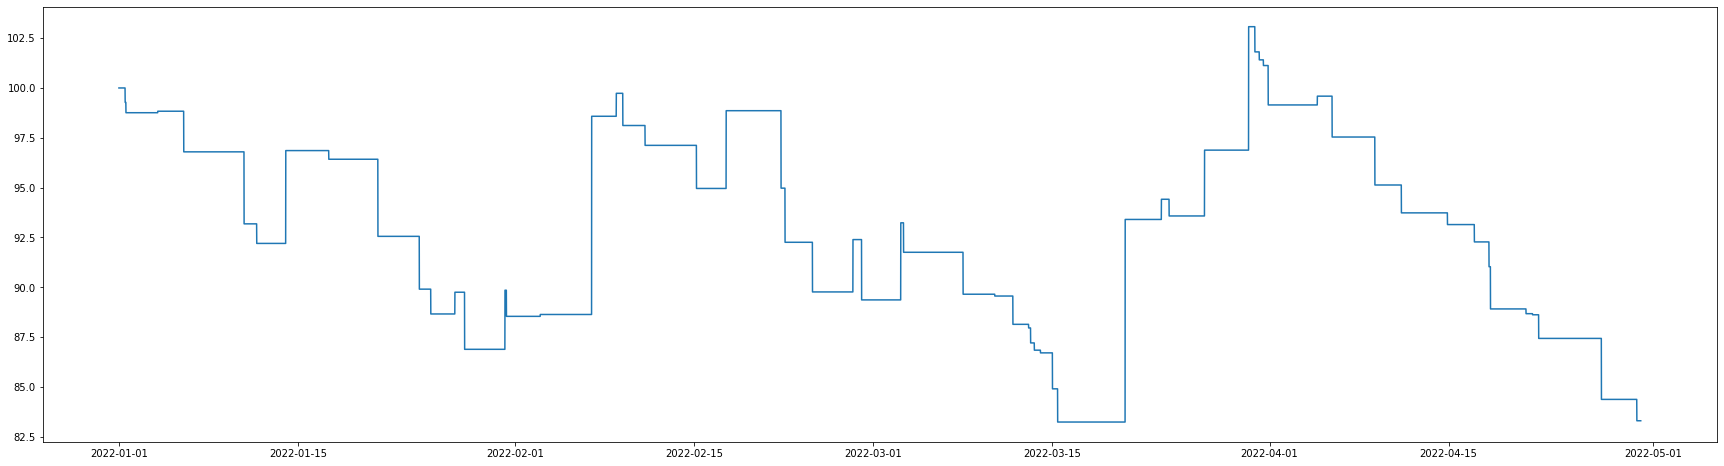

In [18]:
if reinvest_profit_flag == True:
    fig, ax = plt.subplots(figsize=(30, 8))
    ax.plot(budget_dict['time'], budget_dict['budget'])
else:
    print("Not reinvest profit")

In [19]:
if reinvest_profit_flag == True:
    print(f"Max drawdown: {round(max_drawdown * 100, 2)}%")

Max drawdown: 4.34%


In [20]:
win_rate = len(transaction_df[transaction_df['profit'] > 0]) / len(transaction_df)
print(f"Win rate: {round(win_rate * 100, 2)}%")

Win rate: 25.0%


In [21]:
for symbol in transaction_df['symbol'].unique():
    symbol_df = transaction_df[transaction_df['symbol'] == symbol]
    win_rate = len(symbol_df[symbol_df['profit'] > 0]) / len(symbol_df)
    print(f"{symbol} win rate: {round(win_rate * 100, 2)}%")

ETH-PERP win rate: 25.0%


In [22]:
print(f"Distribution")
print(pd.DataFrame(transaction_df['profit_percent'].describe()))

Distribution
       profit_percent
count       60.000000
mean        -0.257201
std          3.136630
min         -4.008182
25%         -2.057780
50%         -0.973882
75%         -0.027531
max         12.199675


In [23]:
for symbol in transaction_df['symbol'].unique():
    temp_return = transaction_df[transaction_df['symbol'] == symbol]['profit_percent']
    
    print(f"Distribution {symbol}:")
    print(pd.DataFrame(temp_return.describe()))
    print("\n")

Distribution ETH-PERP:
       profit_percent
count       60.000000
mean        -0.257201
std          3.136630
min         -4.008182
25%         -2.057780
50%         -0.973882
75%         -0.027531
max         12.199675




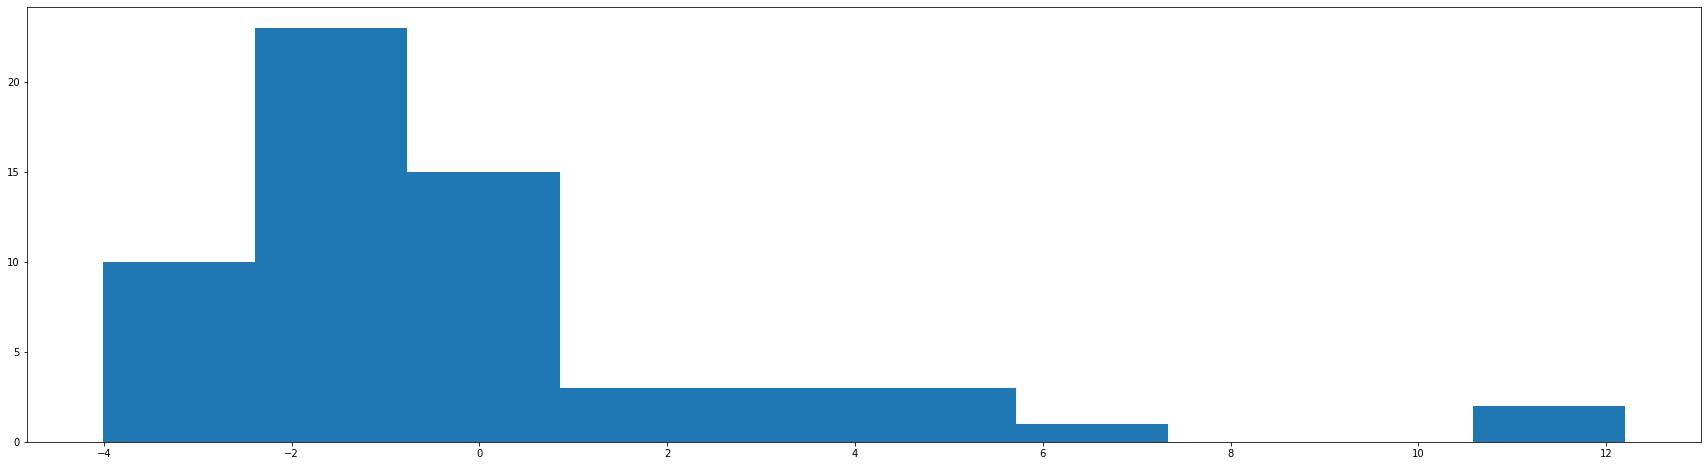

In [24]:
fig, ax = plt.subplots(figsize=(30, 8))
_ = ax.hist(transaction_df['profit_percent'], bins=10)